In [62]:
from google.colab import drive
drive.mount('/content/gdrive')


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [63]:
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [64]:
import pyspark 
from pyspark.ml import Pipeline
from pyspark.ml.linalg import Vectors
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import *
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.sql import Row
from pyspark.sql.types import *
import os
import sys
from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.sql.functions import monotonically_increasing_id 
import numpy as np


In [65]:
from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('BD').getOrCreate()

In [66]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('BD').getOrCreate()

In [67]:
df = spark.read.csv('ML_hw_dataset.csv', header = True, inferSchema = True)
df.show()

+---+-----------+--------+-----------------+-------+-------+----+---------+-----+-----------+--------+--------+-----+--------+-----------+------------+--------------+-------------+---------+-----------+---+
|age|        job| marital|        education|default|housing|loan|  contact|month|day_of_week|duration|campaign|pdays|previous|   poutcome|emp_var_rate|cons_price_idx|cons_conf_idx|euribor3m|nr_employed|  y|
+---+-----------+--------+-----------------+-------+-------+----+---------+-----+-----------+--------+--------+-----+--------+-----------+------------+--------------+-------------+---------+-----------+---+
| 44|blue-collar| married|         basic.4y|unknown|    yes|  no| cellular|  aug|        thu|     210|       1|  999|       0|nonexistent|         1.4|        93.444|        -36.1|    4.963|     5228.1|  0|
| 53| technician| married|          unknown|     no|     no|  no| cellular|  nov|        fri|     138|       1|  999|       0|nonexistent|        -0.1|          93.2|      

In [68]:
from pyspark.sql.functions import countDistinct
from pyspark.sql.functions import count

duplicate_rows = df.groupBy(df.columns).agg(count('*').alias('count')).filter('count > 1')
num_duplicate_rows = duplicate_rows.count()


In [69]:
duplicate_rows.show()

+---+-----------+--------+-------------------+-------+-------+----+---------+-----+-----------+--------+--------+-----+--------+-----------+------------+--------------+-------------+---------+-----------+---+-----+
|age|        job| marital|          education|default|housing|loan|  contact|month|day_of_week|duration|campaign|pdays|previous|   poutcome|emp_var_rate|cons_price_idx|cons_conf_idx|euribor3m|nr_employed|  y|count|
+---+-----------+--------+-------------------+-------+-------+----+---------+-----+-----------+--------+--------+-----+--------+-----------+------------+--------------+-------------+---------+-----------+---+-----+
| 41| technician| married|professional.course|     no|    yes|  no| cellular|  aug|        tue|     127|       1|  999|       0|nonexistent|         1.4|        93.444|        -36.1|    4.966|     5228.1|  0|    2|
| 55|   services| married|        high.school|unknown|     no|  no| cellular|  aug|        mon|      33|       1|  999|       0|nonexistent|

In [70]:
num_duplicate_rows

12

In [71]:
df=df.dropDuplicates()

In [72]:
df = df.select("*").withColumn("id", monotonically_increasing_id())

In [73]:
from pyspark.sql.functions import *
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+---+---+-------+---------+-------+-------+----+-------+-----+-----------+--------+--------+-----+--------+--------+------------+--------------+-------------+---------+-----------+---+---+
|age|job|marital|education|default|housing|loan|contact|month|day_of_week|duration|campaign|pdays|previous|poutcome|emp_var_rate|cons_price_idx|cons_conf_idx|euribor3m|nr_employed|  y| id|
+---+---+-------+---------+-------+-------+----+-------+-----+-----------+--------+--------+-----+--------+--------+------------+--------------+-------------+---------+-----------+---+---+
|  0|  0|      0|        0|      0|      0|   0|      0|    0|          0|       0|       0|    0|       0|       0|           0|             0|            0|        0|          0|  0|  0|
+---+---+-------+---------+-------+-------+----+-------+-----+-----------+--------+--------+-----+--------+--------+------------+--------------+-------------+---------+-----------+---+---+



In [74]:
from pyspark.sql.functions import countDistinct

for col in df.columns:
    print(f"Column {col} has {df.select(countDistinct(col)).collect()[0][0]} unique values")

Column age has 78 unique values
Column job has 12 unique values
Column marital has 4 unique values
Column education has 8 unique values
Column default has 3 unique values
Column housing has 3 unique values
Column loan has 3 unique values
Column contact has 2 unique values
Column month has 10 unique values
Column day_of_week has 5 unique values
Column duration has 1544 unique values
Column campaign has 42 unique values
Column pdays has 27 unique values
Column previous has 8 unique values
Column poutcome has 3 unique values
Column emp_var_rate has 10 unique values
Column cons_price_idx has 26 unique values
Column cons_conf_idx has 26 unique values
Column euribor3m has 316 unique values
Column nr_employed has 11 unique values
Column y has 2 unique values
Column id has 41176 unique values


In [75]:
df.printSchema()


root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- month: string (nullable = true)
 |-- day_of_week: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- emp_var_rate: double (nullable = true)
 |-- cons_price_idx: double (nullable = true)
 |-- cons_conf_idx: double (nullable = true)
 |-- euribor3m: double (nullable = true)
 |-- nr_employed: double (nullable = true)
 |-- y: integer (nullable = true)
 |-- id: long (nullable = false)



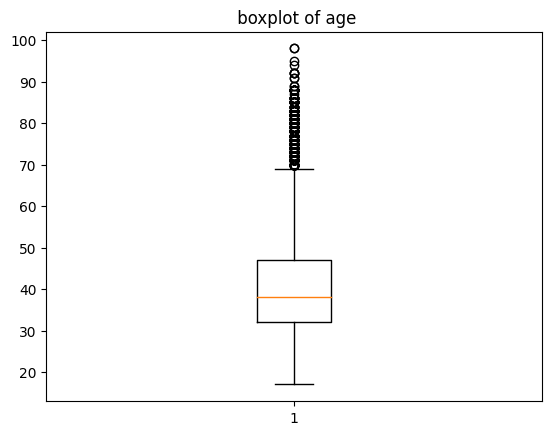

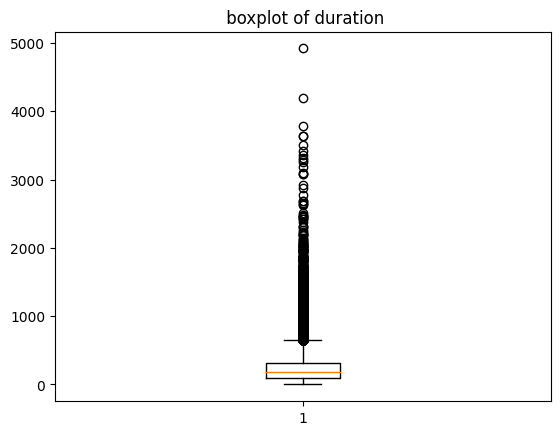

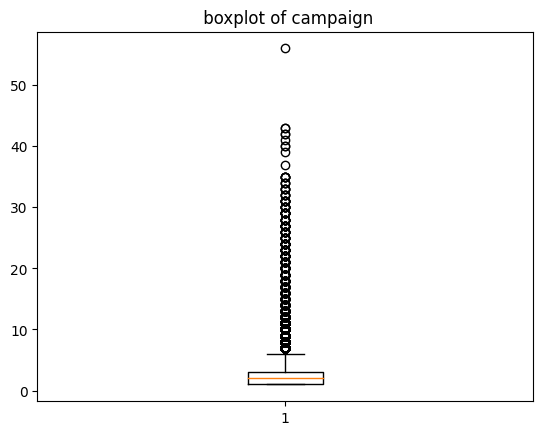

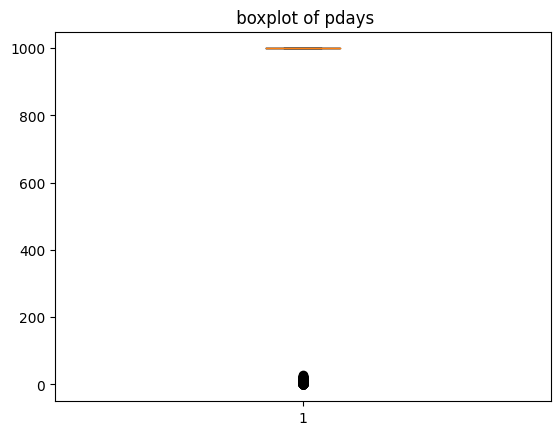

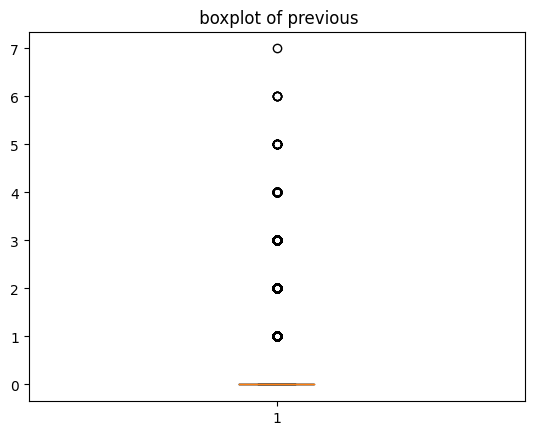

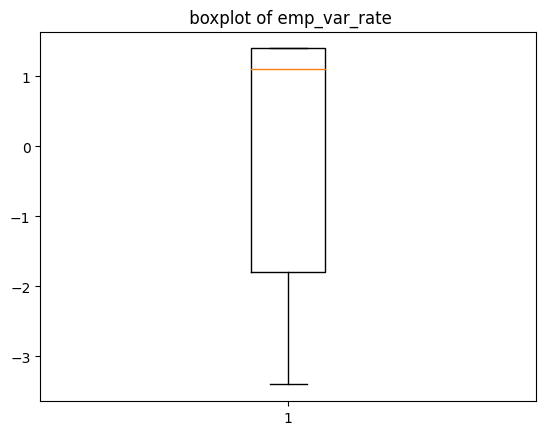

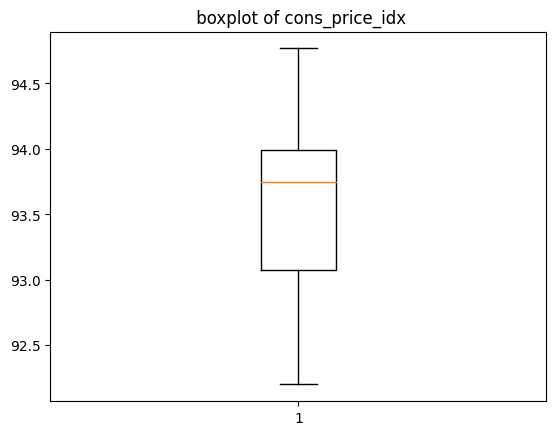

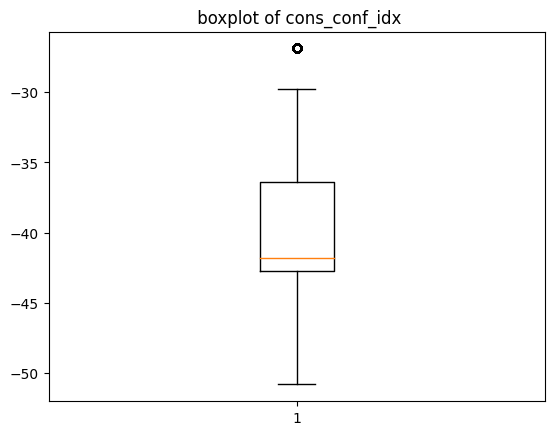

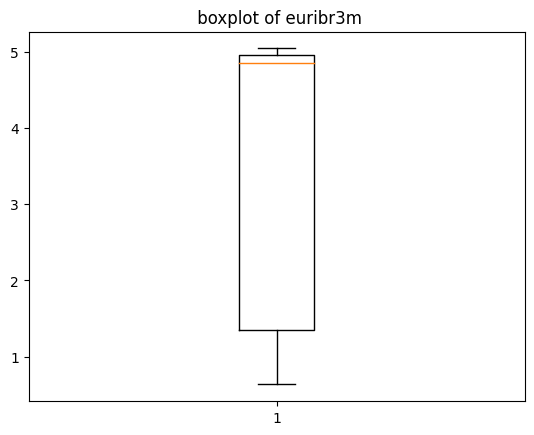

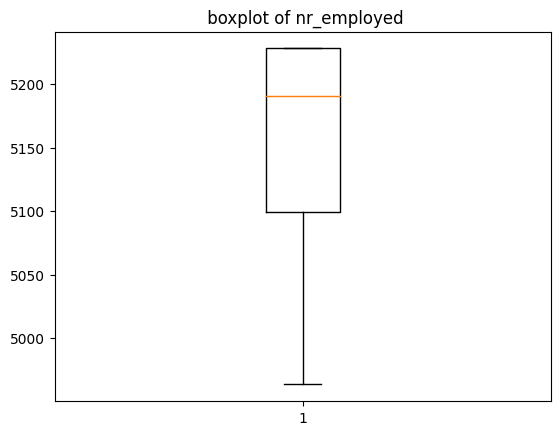

In [76]:
import matplotlib.pyplot as plt
import seaborn as sns
cc=['age','duration','campaign','pdays','previous','emp_var_rate','cons_price_idx','cons_conf_idx','euribr3m','nr_employed']
ii=0
for i in [0,10,11,12,13,15,16,17,18,19]:#['age','duration','campaign','pdays','previous','emp_var_rate','cons_price_idx','cons_conf_idx','euribr3m','nr_employed']:
  bxp = df.select(df.columns[i]).rdd.flatMap(lambda x: x).collect()
  plt.figure()
  plt.boxplot(bxp)
  col=cc[ii]
  ii=ii+1
  plt.title(f" boxplot of {col}")
  plt.show()

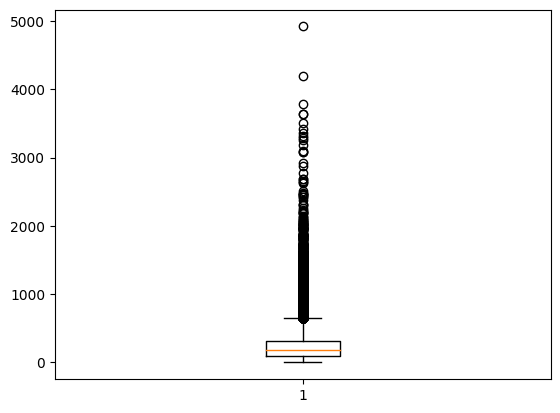

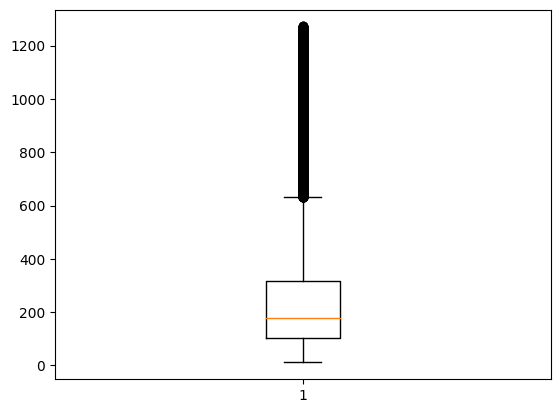

In [77]:
quantiles = df.approxQuantile("duration", [0.01, 0.99], 0)
df_filtered = df.filter((df["duration"] >= quantiles[0]) & (df["duration"] <= quantiles[1]))
bxp = df.select(df.duration).rdd.flatMap(lambda x: x).collect()
plt.figure()
plt.boxplot(bxp)
plt.show()
bxp = df_filtered.select(df_filtered.duration).rdd.flatMap(lambda x: x).collect()
plt.figure()
plt.boxplot(bxp)
plt.show()

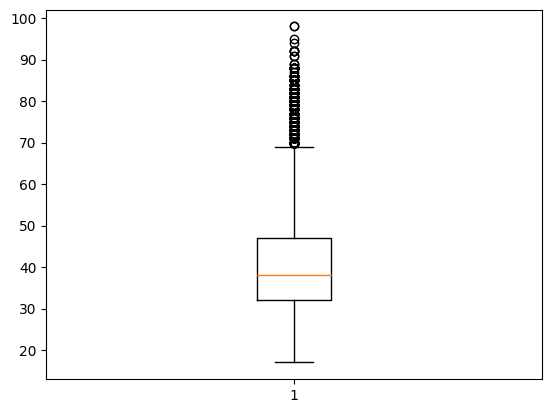

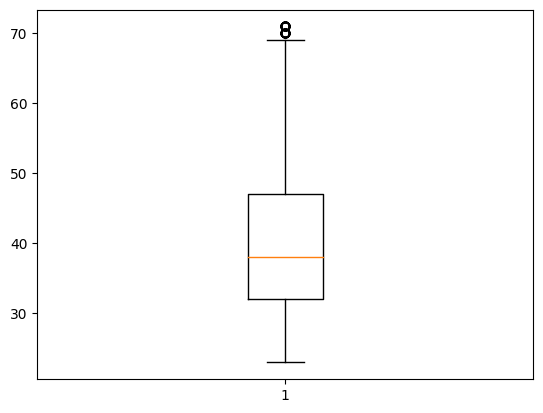

In [78]:
df_filtered=df
quantiles = df.approxQuantile("age", [0.01, 0.99], 0)
df_filtered = df.filter((df["age"] >= quantiles[0]) & (df["age"] <= quantiles[1]))
bxp = df.select(df.age).rdd.flatMap(lambda x: x).collect()
plt.figure()
plt.boxplot(bxp)
plt.show()
bxp = df_filtered.select(df_filtered.age).rdd.flatMap(lambda x: x).collect()
plt.figure()
plt.boxplot(bxp)
plt.show()

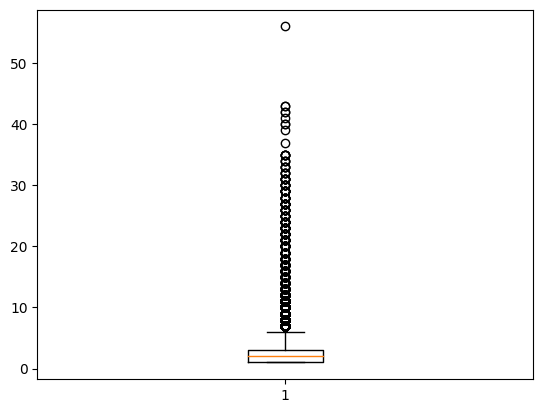

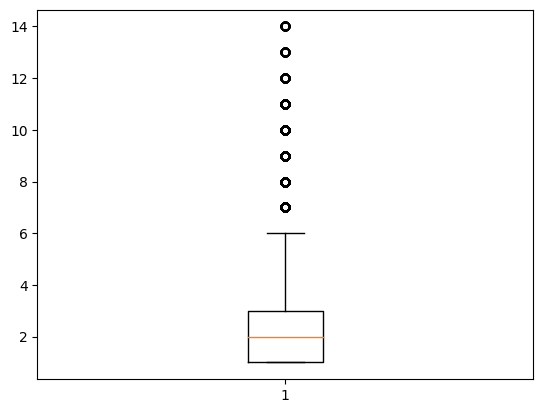

In [79]:
quantiles = df.approxQuantile("campaign", [0.01, 0.99], 0)
df_filtered = df.filter((df["campaign"] >= quantiles[0]) & (df["campaign"] <= quantiles[1]))
bxp = df.select(df.campaign).rdd.flatMap(lambda x: x).collect()
plt.figure()
plt.boxplot(bxp)
plt.show()
bxp = df_filtered.select(df_filtered.campaign).rdd.flatMap(lambda x: x).collect()
plt.figure()
plt.boxplot(bxp)
plt.show()

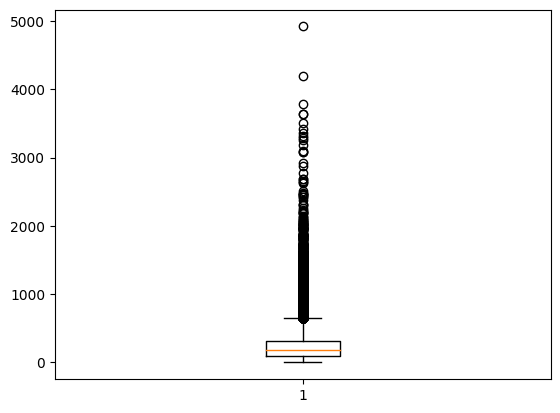

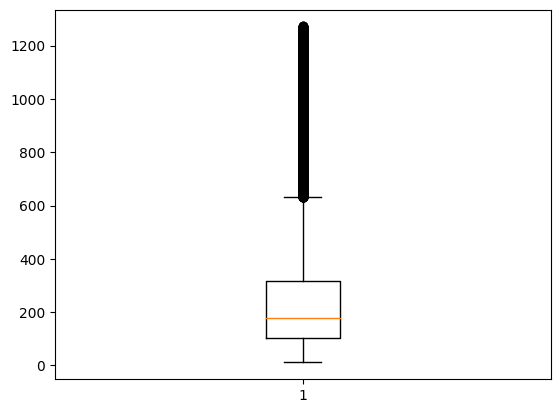

In [80]:
quantiles = df.approxQuantile("duration", [0.01, 0.99], 0)
df_filtered = df.filter((df["duration"] >= quantiles[0]) & (df["duration"] <= quantiles[1]))
bxp = df.select(df.duration).rdd.flatMap(lambda x: x).collect()
plt.figure()
plt.boxplot(bxp)
plt.show()
bxp = df_filtered.select(df_filtered.duration).rdd.flatMap(lambda x: x).collect()
plt.figure()
plt.boxplot(bxp)
plt.show()

In [81]:
categorical_cols=[0]*9
categorical_cols[0:8]=df.columns[1:10]
categorical_cols[9]=df.columns[14]

In [82]:
from pyspark.ml.feature import OneHotEncoder, StringIndexer
indexers = [StringIndexer(inputCol=column, outputCol=column+"_index", handleInvalid='skip')
 for column in categorical_cols]
encoder = OneHotEncoder(inputCols=[indexer.getOutputCol() for indexer in indexers],
 outputCols=[column+"_onehot" for column in categorical_cols])
pipeline = Pipeline(stages=indexers + [encoder])
model = pipeline.fit(df)
transformed_data = model.transform(df)
transformed_data.show(1)

+---+----------+-------+-----------------+-------+-------+----+--------+-----+-----------+--------+--------+-----+--------+-----------+------------+--------------+-------------+---------+-----------+---+---+---------+-------------+---------------+-------------+-------------+----------+-------------+-----------+-----------------+--------------+--------------+--------------+----------------+--------------+--------------+-------------+--------------+-------------+------------------+---------------+
|age|       job|marital|        education|default|housing|loan| contact|month|day_of_week|duration|campaign|pdays|previous|   poutcome|emp_var_rate|cons_price_idx|cons_conf_idx|euribor3m|nr_employed|  y| id|job_index|marital_index|education_index|default_index|housing_index|loan_index|contact_index|month_index|day_of_week_index|poutcome_index|    job_onehot|marital_onehot|education_onehot|default_onehot|housing_onehot|  loan_onehot|contact_onehot| month_onehot|day_of_week_onehot|poutcome_onehot

In [83]:
#numeric_cols=['id','age','duration','campaign','pdays','previous','emp_var_rate','cons_price_idx','cons_conf_idx','euribor3m','nr_employed','job_onehot','marital_onehot','education_onehot','default_onehot','housing_onehot',  'loan_onehot','contact_onehot', 'month_onehot','day_of_week_onehot','poutcome_onehot','y']
#df_new = transformed_data.select('id','age','duration','campaign','pdays','previous','emp_var_rate','cons_price_idx','cons_conf_idx','euribor3m','nr_employed','job_onehot','marital_onehot','education_onehot','default_onehot','housing_onehot',  'loan_onehot','contact_onehot', 'month_onehot','day_of_week_onehot','poutcome_onehot','y')
#df_new.show(5)

In [84]:
from pyspark.sql.functions import corr
numeric_cols=['id','age','duration','campaign','pdays','previous','emp_var_rate','cons_price_idx','euribor3m','nr_employed','job_index','marital_index','education_index','default_index','housing_index',  'loan_index','contact_index', 'month_index','day_of_week_index','poutcome_index','y']
lisst=[]
for col in numeric_cols:
  correlation = transformed_data.select(corr("y", col)).collect()[0][0]
  if correlation>0.1 or correlation<-0.1:
    lisst.append(col)
    print(f"The correlation between 'label' and {col} is {correlation}")
print(lisst)


The correlation between 'label' and duration is 0.4052972612685245
The correlation between 'label' and pdays is -0.32494758638558463
The correlation between 'label' and previous is 0.23020157021544782
The correlation between 'label' and emp_var_rate is -0.2982885042462059
The correlation between 'label' and cons_price_idx is -0.13613397100783664
The correlation between 'label' and euribor3m is -0.3077403955846879
The correlation between 'label' and nr_employed is -0.35466901538267287
The correlation between 'label' and contact_index is -0.1447742166158834
The correlation between 'label' and month_index is 0.22277748761272118
The correlation between 'label' and poutcome_index is 0.2703989464189325
The correlation between 'label' and y is 1.0
['duration', 'pdays', 'previous', 'emp_var_rate', 'cons_price_idx', 'euribor3m', 'nr_employed', 'contact_index', 'month_index', 'poutcome_index', 'y']


In [85]:
df_new = transformed_data.select('id','age','duration','campaign','pdays','previous','emp_var_rate','cons_price_idx','euribor3m','nr_employed','job_index','marital_index','education_index','default_index','housing_index',  'loan_index','contact_index', 'month_index','day_of_week_index','poutcome_index','y')


<Axes: >

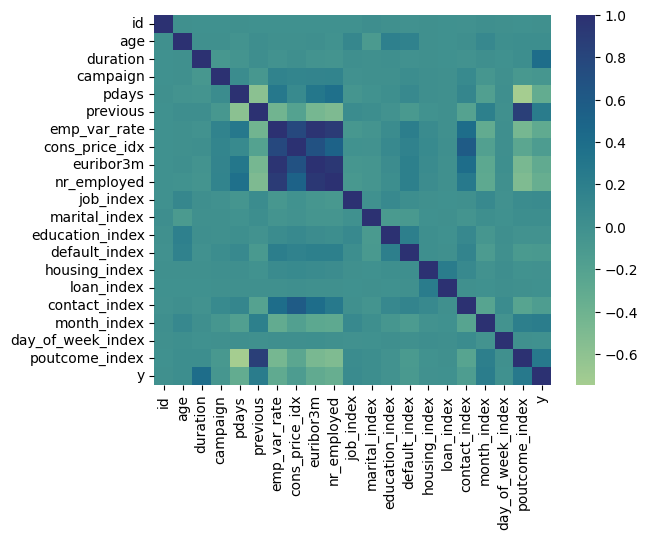

In [86]:
DF=df_new.toPandas()
from seaborn import heatmap
heatmap(DF.corr(),cmap='crest')

In [87]:
df_new = transformed_data.select('duration', 'pdays', 'previous', 'emp_var_rate', 'cons_price_idx', 'euribor3m', 'nr_employed', 'contact_index', 'month_index', 'poutcome_index', 'y')


In [88]:
df_new.show(1)

+--------+-----+--------+------------+--------------+---------+-----------+-------------+-----------+--------------+---+
|duration|pdays|previous|emp_var_rate|cons_price_idx|euribor3m|nr_employed|contact_index|month_index|poutcome_index|  y|
+--------+-----+--------+------------+--------------+---------+-----------+-------------+-----------+--------------+---+
|     116|  999|       0|        -1.8|        92.843|    1.811|     5099.1|          0.0|        8.0|           0.0|  1|
+--------+-----+--------+------------+--------------+---------+-----------+-------------+-----------+--------------+---+
only showing top 1 row



In [89]:
hasher = FeatureHasher(inputCols=['duration', 'pdays', 'previous', 'emp_var_rate', 'cons_price_idx', 'euribor3m', 'nr_employed', 'contact_index', 'month_index', 'poutcome_index'],
                       outputCol="features")
featurized = hasher.transform(df_new)
featurized.show(1)

+--------+-----+--------+------------+--------------+---------+-----------+-------------+-----------+--------------+---+--------------------+
|duration|pdays|previous|emp_var_rate|cons_price_idx|euribor3m|nr_employed|contact_index|month_index|poutcome_index|  y|            features|
+--------+-----+--------+------------+--------------+---------+-----------+-------------+-----------+--------------+---+--------------------+
|     116|  999|       0|        -1.8|        92.843|    1.811|     5099.1|          0.0|        8.0|           0.0|  1|(262144,[13117,38...|
+--------+-----+--------+------------+--------------+---------+-----------+-------------+-----------+--------------+---+--------------------+
only showing top 1 row



In [90]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler
numeric_cols = ['duration', 'pdays', 'previous', 'emp_var_rate', 'cons_price_idx', 'euribor3m', 'nr_employed', 'contact_index', 'month_index', 'poutcome_index']
assembler = VectorAssembler(inputCols=numeric_cols, outputCol="features")
output = assembler.transform(df_new).select("features",'y')
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures",
         withStd=True, withMean=False)
scalerModel = scaler.fit(output)
scaledData = scalerModel.transform(output)
scaledData.show()

+--------------------+---+--------------------+
|            features|  y|      scaledFeatures|
+--------------------+---+--------------------+
|[116.0,999.0,0.0,...|  1|[0.44734909246408...|
|[146.0,999.0,0.0,...|  0|[0.56304282327375...|
|[120.0,999.0,0.0,...|  0|[0.46277492323870...|
|[209.0,999.0,0.0,...|  0|[0.80599965797407...|
|[454.0,999.0,0.0,...|  0|[1.75083179291976...|
|[348.0,999.0,0.0,...|  0|[1.34204727739224...|
|[145.0,999.0,0.0,...|  0|[0.55918636558010...|
|[245.0,999.0,1.0,...|  0|[0.94483213494568...|
|[351.0,999.0,0.0,...|  0|[1.35361665047320...|
|[207.0,999.0,0.0,...|  0|[0.79828674258676...|
|[94.0,999.0,0.0,1...|  0|[0.36250702320365...|
|[415.0,999.0,0.0,...|  0|[1.60042994286718...|
|[202.0,999.0,0.0,...|  0|[0.77900445411848...|
|[115.0,999.0,0.0,...|  0|[0.44349263477042...|
|[84.0,999.0,0.0,1...|  0|[0.32394244626709...|
|[401.0,999.0,0.0,...|  1|[1.54643953515600...|
|[265.0,999.0,0.0,...|  0|[1.02196128881880...|
|[49.0,999.0,0.0,-...|  0|[0.18896642698

In [91]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import BinaryClassificationEvaluator

train_data, test_data =scaledData.randomSplit([0.8, 0.2], seed=100)
accuracy=0
Recall=0
Precision=0
F_Measure=0
n=10
for i in range(n):
  lr = LogisticRegression(labelCol="y", featuresCol="scaledFeatures")
  lrModel = lr.fit(train_data)
  predictions = lrModel.transform(test_data)
  #predictions.show()
  evaluator = BinaryClassificationEvaluator(labelCol="y",rawPredictionCol="rawPrediction")
  predictions = lrModel.transform(test_data)
  predictions.groupBy('y', 'prediction').count().show()
  TN = predictions.filter('prediction = 0 AND y = prediction').count()
  TP = predictions.filter('prediction = 1 AND y = prediction').count()
  FN = predictions.filter('prediction = 0 AND y = 1').count()
  FP = predictions.filter('prediction = 1 AND y = 0').count()
  accuracy =accuracy+ (TN + TP) / (TN + TP + FN + FP)
  Precision =Precision+ TP/(TP+FP)
  Recall =Recall+ TP/(TP+FN)
  F_Measure=F_Measure+(2*Precision*Recall)/(Precision+Recall)

print(accuracy/n)
print(Precision/n)
print(Recall/n)
print(F_Measure/n)

+---+----------+-----+
|  y|prediction|count|
+---+----------+-----+
|  1|       0.0|  569|
|  0|       0.0| 7083|
|  1|       1.0|  362|
|  0|       1.0|  200|
+---+----------+-----+

+---+----------+-----+
|  y|prediction|count|
+---+----------+-----+
|  1|       0.0|  569|
|  0|       0.0| 7083|
|  1|       1.0|  362|
|  0|       1.0|  200|
+---+----------+-----+

+---+----------+-----+
|  y|prediction|count|
+---+----------+-----+
|  1|       0.0|  569|
|  0|       0.0| 7083|
|  1|       1.0|  362|
|  0|       1.0|  200|
+---+----------+-----+

+---+----------+-----+
|  y|prediction|count|
+---+----------+-----+
|  1|       0.0|  569|
|  0|       0.0| 7083|
|  1|       1.0|  362|
|  0|       1.0|  200|
+---+----------+-----+

+---+----------+-----+
|  y|prediction|count|
+---+----------+-----+
|  1|       0.0|  569|
|  0|       0.0| 7083|
|  1|       1.0|  362|
|  0|       1.0|  200|
+---+----------+-----+

+---+----------+-----+
|  y|prediction|count|
+---+----------+-----+
|  1| 

In [92]:
##بدون هیچ پیش پردازش

In [93]:
hasher = FeatureHasher(inputCols=['age',
 'job',
 'marital',
 'education',
 'default',
 'housing',
 'loan',
 'contact',
 'month',
 'day_of_week',
 'duration',
 'campaign',
 'pdays',
 'previous',
 'poutcome',
 'emp_var_rate',
 'cons_price_idx',
 'cons_conf_idx',
 'euribor3m',
 'nr_employed'], outputCol="features")
featurized = hasher.transform(df)
featurized.show(1)

+---+----------+-------+-----------------+-------+-------+----+--------+-----+-----------+--------+--------+-----+--------+-----------+------------+--------------+-------------+---------+-----------+---+---+--------------------+
|age|       job|marital|        education|default|housing|loan| contact|month|day_of_week|duration|campaign|pdays|previous|   poutcome|emp_var_rate|cons_price_idx|cons_conf_idx|euribor3m|nr_employed|  y| id|            features|
+---+----------+-------+-----------------+-------+-------+----+--------+-----+-----------+--------+--------+-----+--------+-----------+------------+--------------+-------------+---------+-----------+---+---+--------------------+
| 30|management|married|university.degree|     no|     no|  no|cellular|  mar|        mon|     116|       1|  999|       0|nonexistent|        -1.8|        92.843|        -50.0|    1.811|     5099.1|  1|  0|(262144,[12449,29...|
+---+----------+-------+-----------------+-------+-------+----+--------+-----+------

In [94]:
new_accuracy=0
new_Precision=0
new_Recall=0
new_F_Measure=0
for i in range(n):
  train_data, test_data =featurized.randomSplit([0.8, 0.2], seed=100)

  lr = LogisticRegression(labelCol="y", featuresCol="features")
  lrModel = lr.fit(train_data)
  predictions = lrModel.transform(test_data)
  #predictions.show()
  evaluator = BinaryClassificationEvaluator(labelCol="y",rawPredictionCol="rawPrediction")
  predictions = lrModel.transform(test_data)
  predictions.groupBy('y', 'prediction').count().show()
  TN = predictions.filter('prediction = 0 AND y = 0').count()
  TP = predictions.filter('prediction = 1 AND y = 1').count()
  FN = predictions.filter('prediction = 0 AND y = 1').count()
  FP = predictions.filter('prediction = 1 AND y = 0').count()
  new_accuracy =new_accuracy+ (TN + TP) / (TN + TP + FN + FP)
  new_Precision = new_Precision+TP/(TP+FP)
  new_Recall =new_Recall+ TP/(TP+FN)
  new_F_Measure=new_F_Measure+(2*new_Precision*new_Recall)/(new_Precision+new_Recall)

print(new_F_Measure/n)
print(new_accuracy/n)
print(new_Precision/n)
print(new_Recall/n)

+---+----------+-----+
|  y|prediction|count|
+---+----------+-----+
|  1|       0.0|  551|
|  0|       0.0| 7054|
|  1|       1.0|  412|
|  0|       1.0|  197|
+---+----------+-----+

+---+----------+-----+
|  y|prediction|count|
+---+----------+-----+
|  1|       0.0|  551|
|  0|       0.0| 7054|
|  1|       1.0|  412|
|  0|       1.0|  197|
+---+----------+-----+

+---+----------+-----+
|  y|prediction|count|
+---+----------+-----+
|  1|       0.0|  551|
|  0|       0.0| 7054|
|  1|       1.0|  412|
|  0|       1.0|  197|
+---+----------+-----+

+---+----------+-----+
|  y|prediction|count|
+---+----------+-----+
|  1|       0.0|  551|
|  0|       0.0| 7054|
|  1|       1.0|  412|
|  0|       1.0|  197|
+---+----------+-----+

+---+----------+-----+
|  y|prediction|count|
+---+----------+-----+
|  1|       0.0|  551|
|  0|       0.0| 7054|
|  1|       1.0|  412|
|  0|       1.0|  197|
+---+----------+-----+

+---+----------+-----+
|  y|prediction|count|
+---+----------+-----+
|  1| 

In [95]:
rows = scaledData.count()
cols = len(scaledData.columns)
print("Total rows: ", rows)
print("Total columns: ", cols)

Total rows:  41176
Total columns:  3


In [96]:
transformed_data.show(1)


+---+----------+-------+-----------------+-------+-------+----+--------+-----+-----------+--------+--------+-----+--------+-----------+------------+--------------+-------------+---------+-----------+---+---+---------+-------------+---------------+-------------+-------------+----------+-------------+-----------+-----------------+--------------+--------------+--------------+----------------+--------------+--------------+-------------+--------------+-------------+------------------+---------------+
|age|       job|marital|        education|default|housing|loan| contact|month|day_of_week|duration|campaign|pdays|previous|   poutcome|emp_var_rate|cons_price_idx|cons_conf_idx|euribor3m|nr_employed|  y| id|job_index|marital_index|education_index|default_index|housing_index|loan_index|contact_index|month_index|day_of_week_index|poutcome_index|    job_onehot|marital_onehot|education_onehot|default_onehot|housing_onehot|  loan_onehot|contact_onehot| month_onehot|day_of_week_onehot|poutcome_onehot

In [97]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler
df_new = transformed_data.select('age','campaign','job_index','marital_index','education_index','default_index','housing_index','duration', 'pdays', 'previous', 'emp_var_rate', 'cons_price_idx', 'euribor3m', 'nr_employed', 'contact_index', 'month_index', 'poutcome_index', 'y')
numeric_cols = ['age','campaign','job_index','marital_index','education_index','default_index','housing_index','duration', 'pdays', 'previous', 'emp_var_rate', 'cons_price_idx', 'euribor3m', 'nr_employed', 'contact_index', 'month_index', 'poutcome_index']
assembler = VectorAssembler(inputCols=numeric_cols, outputCol="features")
output = assembler.transform(df_new).select("features",'y')
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures",
    withStd=True, withMean=False)
scalerModel = scaler.fit(output)
scaledData = scalerModel.transform(output)
scaledData.show()
accuracy=0
Precision=0
Recall=0
F_Measure=0
for i in range(10):
  train_data, test_data =scaledData.randomSplit([0.8, 0.2], seed=100)
  lr = LogisticRegression(labelCol="y", featuresCol="scaledFeatures")
  lrModel = lr.fit(train_data)
  predictions = lrModel.transform(test_data)
  #predictions.show()
  evaluator = BinaryClassificationEvaluator(labelCol="y",rawPredictionCol="rawPrediction")
  predictions = lrModel.transform(test_data)
  predictions.groupBy('y', 'prediction').count().show()
  TN = predictions.filter('prediction = 0 AND y = 0').count()
  TP = predictions.filter('prediction = 1 AND y = 1').count()
  FN = predictions.filter('prediction = 0 AND y = 1').count()
  FP = predictions.filter('prediction = 1 AND y = 0').count()
  accuracy =accuracy+ (TN + TP) / (TN + TP + FN + FP)
  Precision =Precision+ TP/(TP+FP)
  Recall =Recall+ TP/(TP+FN)
  F_Measure=F_Measure+(2*Precision*Recall)/(Precision+Recall)
print(accuracy/n)
print(Precision/n)
print(Recall/n)
print(F_Measure/n)

+--------------------+---+--------------------+
|            features|  y|      scaledFeatures|
+--------------------+---+--------------------+
|[30.0,1.0,4.0,0.0...|  1|[2.87889085715131...|
|[34.0,1.0,0.0,0.0...|  0|[3.26274297143815...|
|[27.0,1.0,9.0,1.0...|  0|[2.59100177143618...|
|[32.0,1.0,10.0,1....|  0|[3.07081691429473...|
|[30.0,18.0,3.0,1....|  0|[2.87889085715131...|
|[48.0,2.0,1.0,0.0...|  0|[4.60622537144210...|
|(17,[0,1,6,7,8,10...|  0|(17,[0,1,6,7,8,10...|
|[33.0,5.0,0.0,0.0...|  0|[3.16677994286644...|
|[53.0,1.0,0.0,1.0...|  0|[5.08604051430065...|
|(17,[0,1,4,7,8,10...|  0|(17,[0,1,4,7,8,10...|
|[55.0,1.0,1.0,0.0...|  0|[5.27796657144407...|
|[55.0,1.0,0.0,1.0...|  0|[5.27796657144407...|
|(17,[0,1,4,6,7,8,...|  0|(17,[0,1,4,6,7,8,...|
|[48.0,2.0,4.0,0.0...|  0|[4.60622537144210...|
|[27.0,14.0,9.0,0....|  0|[2.59100177143618...|
|[34.0,1.0,9.0,1.0...|  1|[3.26274297143815...|
|[40.0,2.0,4.0,0.0...|  0|[3.83852114286841...|
|[63.0,3.0,5.0,0.0...|  0|[6.04567080001